In [1]:
# http://gouthamanbalaraman.com/blog/american-option-pricing-quantlib-python.html
import QuantLib as ql
import matplotlib.pyplot as plt
import pandas as pd
import datetime
%matplotlib inline
ql.__version__

'1.23'

In [98]:
# Related:
# iv http://options-scanner.com/index.php?page=atm-implied-volatility
# https://warrants.ubs.com/en/warrants/warrants_analyzer_performance/code/11051
# https://quantlib-python-docs.readthedocs.io/en/latest/instruments/options.html
# https://www.wiley.com/en-gb/Option+Pricing+and+Estimation+of+Financial+Models+with+R-p-9780470745847
# https://quant.stackexchange.com/questions/33964/is-there-any-useful-links-for-option-pricing-american-asian-european-using
# https://leanpub.com/quantlibpythoncookbook

In [3]:
df = pd.read_csv('./data/0914.options.csv')
df.head()

,type,underlying,strike,dividendYield,riskFreeRate,expiry,volatility
0,call,39.55,39,6.48,0.001,29/6/22,23


In [30]:
dfd = df.to_dict(orient='records')[0]
dfd

{'type': 'call',
 'underlying': 39.55,
 'strike': 39,
 'dividendYield': 6.48,
 'riskFreeRate': 0.001,
 'expiry': '29/6/22',
 'volatility': 23}

In [5]:
def get_o_type(type):
    if (type == 'call'):
        return ql.Option.Call
    elif (type == 'put'):
        return ql.Option.Put

In [6]:
def get_payoff_settl(cp, strike, calc_date):
    payoff = ql.PlainVanillaPayoff(cp, strike)
    settlement = calc_date
    return payoff, settlement

In [212]:
def get_black_scholes_proc(**a):
    # day_count, cal is different
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(a['spot']))
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(a['calc_date'], a['rfr'], a['day_count']))
    dyield = ql.YieldTermStructureHandle(ql.FlatForward(a['calc_date'], a['div_rate'], a['day_count']))
    flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(a['calc_date'], a['cal'], a['iv'], a['day_count']))
    bsmp = ql.BlackScholesMertonProcess(spot_handle, dyield, flat_ts, flat_vol_ts)
    return bsmp

In [218]:
def get_option_price(otype, spot, strike, dyield, rfr, exp, iv):
    risk_free_rate = rfr
    day_count = ql.Actual365Fixed()
    calendar = ql.UnitedStates()
    now = datetime.datetime.now()
    calculation_date = ql.Date(now.day, now.month, now.year)
    ql.Settings.instance().evaluationDate = calculation_date
    d,m,y = exp.split('/')
    # probably fix date handling
    maturity_date = ql.Date(int(d),int(m),int(y) + 2000)
    spot_price = spot
    strike_price = strike
    volatility = iv / 100 # the historical vols or iv
    dividend_rate = dyield / 100
    option_type = get_o_type(otype)
    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    payoff, settl = get_payoff_settl(option_type, strike, calculation_date)
    am_exercise = ql.AmericanExercise(settl, maturity_date)
    am_option = ql.VanillaOption(payoff, am_exercise)
    bsm_process = get_black_scholes_proc(
        spot=spot,
        calc_date=calculation_date,
        rfr = rfr,
        div_rate=dividend_rate,
        cal=calendar,
        iv=volatility,
        day_count=day_count
    )
    steps = 200
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    am_option.setPricingEngine(binomial_engine)
    print('am NPV: ', am_option.NPV())
    return am_option, bsm_process

In [219]:
def binomial_price(option, bsm_process, steps):
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    option.setPricingEngine(binomial_engine)
    return option.NPV()

In [220]:
american_option, bsm_process = get_option_price(dfd['type'],
                  dfd['underlying'],
                  dfd['strike'],
                  dfd['dividendYield'],
                  dfd['riskFreeRate'],
                  dfd['expiry'],
                  dfd['volatility'])
steps = range(5, 200, 1)
am_prices = [binomial_price(american_option, bsm_process, step) for step in steps]

am NPV:  2.8516240245326188


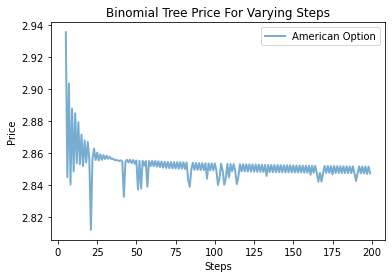

In [231]:
plt.plot(steps, am_prices, label="American Option", lw=2, alpha=0.6)
plt.xlabel("Steps")
plt.ylabel("Price")
plt.title("Binomial Tree Price For Varying Steps")
plt.legend()